In [46]:
%run descent_tools.ipynb

[[4, -11, 13], [2, -11, 13], [3, -10, 13], [3, -12, 13], [3, -11, 14], [3, -11, 12]]


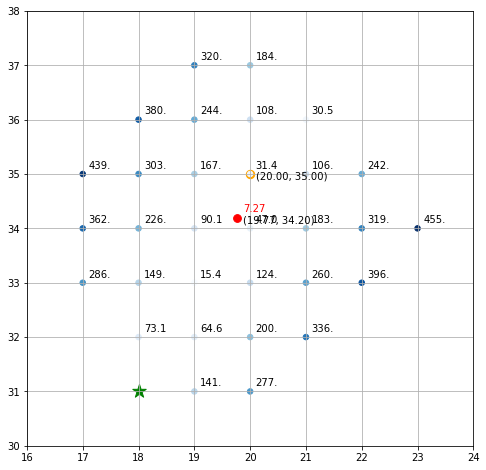

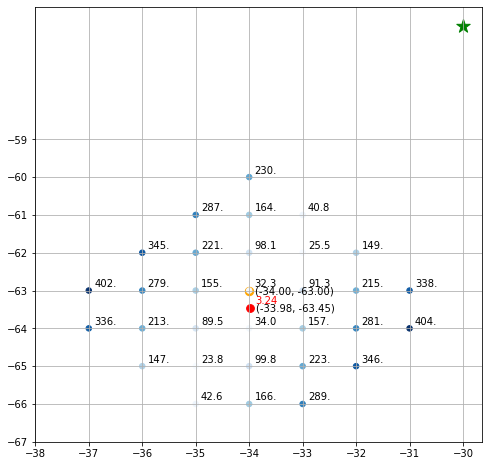

Reached the same LC as LLL in 0 cases, havent reached in 2 cases, success rate 0.0.


[[[19.77081298828125, 34.19781494140625, 1.0], [20, 35, 1], [18.0, 31.0, 1.0]],
 [[-33.9813232421875, -63.4517822265625, -1.0],
  [-34, -63, -1],
  [-30.0, -56.0, -1.0]]]

In [3]:
%run descent_tools.ipynb
reached, pathways = descent("matrices3x3highsensitivity(3).json")
c = reached.count(True)
d = reached.count(False)

print("Reached the same LC as LLL in {} cases, havent reached in {} cases, success rate {}.".format(c, d, float(100*c/(c+d))))
pathways

In [ ]:
reached = descent("matrices6x6-600instances.json")[0]
a = reached.count(True)
b = reached.count(False)

print("Reached the same LC as LLL in {} cases, havent reached in {} cases, success rate {}.".format(a, b, float(100*a/(a+b))))

In [ ]:
# # This result has been generated using the BIG big cube function.

# reached = descent("matrices3x3-600instances.json")[0]
# c = reached.count(True)
# d = reached.count(False)

# print("Reached the same LC as LLL in {} cases, havent reached in {} cases, success rate {}.".format(c, d, float(100*c/(c+d))))

# # Reached the same LC as LLL in 259 cases, havent reached in 416 cases, success rate 38.370370370370374.

What if I start the ascent in the closest point? It doesnt make much sense, as I am not able to compute the closest point without knowledge of the LLL linear combination, but im just curious rn.

In [ ]:
e, f = descent_from_closest("matrices6x6-600instances.json")

print("Reached the same LC as LLL in {} cases, havent reached in {} cases, success rate {}.".format(e, f, 100*e/(e+f).n(digits=3)))


g, h = descent_from_closest("matrices3x3-600instances.json")


print("Reached the same LC as LLL in {} cases, havent reached in {} cases, success rate {}.".format(g, h, 100*g/(g+h).n(digits=3)))


In [ ]:
# This part of code is meant to generate the precise points the algorithm took during the descent. 


for result, pathway in zip(reached, pathways):
    plot_pathway(pathway, result)

